### Important paper
#### Noiseless case

#### Noisy case
[T.Tony Cai and Lie Wang (2011) Orthogonal Matching Pursuit for Sparse Signal Recovery With Noise](https://math.mit.edu/~liewang/OMP.pdf)

[Tong Zhang (2009) On the Consistency of Feature Selection
using Greedy Least Squares Regression](https://www.jmlr.org/papers/volume10/zhang09a/zhang09a.pdf)


### Important Definitions
Mutual Incoherence



In [230]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

# generate SEM
import sys
sys.path.append("..")

import scipy.stats as scistats

import helper.helper as h
import helper.methods as m
import notears.notears.notears.utils as utils

from importlib import reload  # Python 3.4+

In [2]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

### Simple Code Example (VAR)

In [122]:
np.random.seed(seed = 12345)

## Number of dimensions, number of edges, number of samples
T, n, s = 1000, 3, 3

N = int(n * (n + 1) / 2)

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
W_true = h.generate_A(n, s, tril = False, low = 0.30, high = 0.70)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(W_true)):
    W_true[i][i] = 0.4

s = len(W_true.flatten().nonzero()[0])

## Datagenerating W
print(f"True W:\n{np.round(W_true, 2)}.\n")

True W:
[[ 0.4   0.    0.  ]
 [-0.35  0.4   0.  ]
 [ 0.63  0.    0.4 ]].



### Residual for VAR

In [195]:
reload(m)
residuals, T = np.array([]), 5000

In [243]:
total = 2500

for _ in tqdm(range(total)):
    X = utils.simulate_var(W_true, T)
    # Y = X @ W_true + np.random.normal(0, sigma, T * n).reshape(T, n)
    
    W_K, r = m._K_OMP(X[:-1], X[1:], tol = 5, normalize = True) #, tol_res = get_tol(quant, T, sigma, n), verbose = False) #get_tol(0.05, T, sigma), verbose = False)
    residuals = np.append(residuals, r)
    

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:35<00:00, 11.60it/s]


In [207]:
total = 100

for _ in tqdm(range(total)):
    X = h.generate_var_2(T, n, W_true, np.identity(n))
    # Y = X @ W_true + np.random.normal(0, sigma, T * n).reshape(T, n)
    
    W_K, r = m._K_OMP(X[:-1], X[1:], tol = 5, normalize = True) #, tol_res = get_tol(quant, T, sigma, n), verbose = False) #get_tol(0.05, T, sigma), verbose = False)
    residuals = np.append(residuals, r)
# print(correct / total)
# print(quant)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


### Distribution of residuals
Assuming the true model, we have that
$$||\epsilon_i||^2_2 \sim \mathcal{N}(T \sigma^2, 2 T \sigma^4)$$

In [244]:
r2 = residuals.copy()
print(f"Mean of Residual-2-norm squared, should be close to {n * T * sigma ** 2}: {round(np.mean(r2), 3)}.")
r2 -= sigma ** 2 * T * n
print(f"Variance of Residual-2-norm squared, should be close to {T * sigma ** 4 * 2 * n}: {round(np.var(r2), 3)}.")
r2 /= (np.sqrt(T * sigma ** 4 * 2 * n))
print(f"Standardized, should be standard normal: N({round(np.mean(r2), 2)}, {round(np.var(r2), 2)}).")

Mean of Residual-2-norm squared, should be close to 15000: 14993.212.
Variance of Residual-2-norm squared, should be close to 30000: 30197.684.
Standardized, should be standard normal: N(-0.04, 1.01).


#### QQ-Plot of the standardized residuals

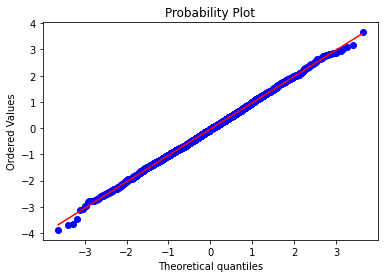

In [256]:
res = scistats.probplot(r2, dist="norm", plot = plt)

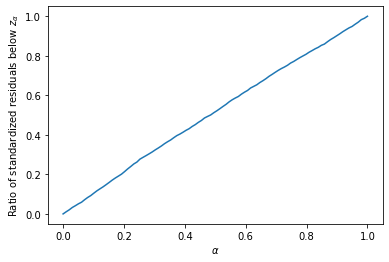

In [267]:
a = []
for q in np.linspace(0.00, 1.00, 100):
    a.append(len(residuals[residuals < get_tol(q, T, sigma, n)]) / np.shape(residuals)[0])

plt.xlabel(r"$\alpha$")
plt.ylabel(r"Ratio of standardized residuals below $z_{\alpha}$")
plt.plot(np.linspace(0.00, 1.00, 100), a)

In [305]:
def get_tol(quant, T, sigma, n):
    return (scistats.norm.ppf(quant) * np.sqrt(2 * T * sigma ** 4 * n) + T * sigma ** 2 * n)

In [304]:
scistats.normaltest(residuals.flatten())

NormaltestResult(statistic=1.510756319134682, pvalue=0.4698329093224436)

#### Histogram of the standardized residuals

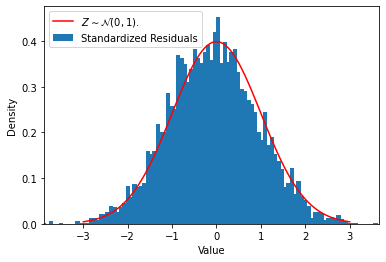

In [302]:
hist, bin_edges = np.histogram(r2, bins = 100, density = True)
plt.bar(bin_edges[:-1], hist, width = 0.1, label = "Standardized Residuals")
plt.plot(x, scistats.norm.pdf(np.linspace(-3, 3, 100), 0, 1), color = 'red', label = r"$Z \sim \mathcal{N}(0, 1)$.")
plt.xlim(min(bin_edges), max(bin_edges))
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()   

#### Residuals for SEM

In [336]:
reload(m)
residuals_sem, T, sigma = np.array([]), 50000, 2

In [346]:
total = 10000

for _ in tqdm(range(total)):
    X = np.random.rand(T, n) - 0.5
    Y = X @ W_true + np.random.normal(0, sigma, T * n).reshape(T, n)
    
    W_K, r = m._K_OMP(X, Y, tol = 5, normalize = True, verbose = False) #, tol_res = get_tol(quant, T, sigma, n), verbose = False) #get_tol(0.05, T, sigma), verbose = False)
    residuals_sem = np.append(residuals_sem, r)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:48<00:00, 43.75it/s]


In [347]:
r_sem = residuals_sem.copy()
print(f"Mean of Residual-2-norm squared, should be close to {n * T * sigma ** 2}: {round(np.mean(r_sem), 3)}.")
r_sem -= sigma ** 2 * T * n
print(f"Variance of Residual-2-norm squared, should be close to {T * sigma ** 4 * 2 * n}: {round(np.var(r_sem), 3)}.")
r_sem /= (np.sqrt(T * sigma ** 4 * 2 * n))
print(f"Standardized, should be standard normal: N({round(np.mean(r_sem), 2)}, {round(np.var(r_sem), 2)}).")

Mean of Residual-2-norm squared, should be close to 600000: 599955.857.
Variance of Residual-2-norm squared, should be close to 4800000: 4868691.977.
Standardized, should be standard normal: N(-0.02, 1.01).


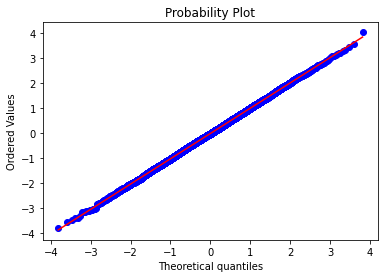

In [348]:
res = scistats.probplot(r_sem, dist="norm", plot = plt)

In [349]:
scistats.normaltest(residuals_sem)

NormaltestResult(statistic=0.07724613618884535, pvalue=0.9621132920040865)

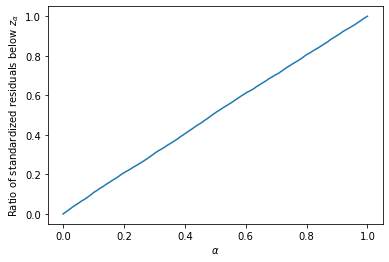

In [350]:
a = []
for q in np.linspace(0.00, 1.00, 100):
    a.append(len(residuals_sem[residuals_sem < get_tol(q, T, sigma, n)]) / np.shape(residuals_sem)[0])

plt.xlabel(r"$\alpha$")
plt.ylabel(r"Ratio of standardized residuals below $z_{\alpha}$")
plt.plot(np.linspace(0.00, 1.00, 100), a)

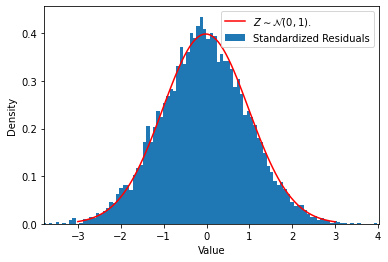

In [359]:
n_bins = 100
hist, bin_edges = np.histogram(r_sem, bins = n_bins, density = True)
plt.bar(bin_edges[:-1], hist, width = 8 / n_bins, label = "Standardized Residuals")
plt.plot(x, scistats.norm.pdf(np.linspace(-3, 3, 100), -0.02, 1), color = 'red', label = r"$Z \sim \mathcal{N}(0, 1)$.")
plt.xlim(min(bin_edges), max(bin_edges))
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()   

#### Residuals for SEM, smaller sample

In [410]:
reload(m)
residuals_sem, T, sigma = np.array([]), 500, 2

In [450]:
total = 1000

for _ in tqdm(range(total)):
    X = np.random.rand(T, n) - 0.5
    Y = X @ W_true + np.random.normal(0, sigma, T * n).reshape(T, n)
    
    W_K, r = m._K_OMP(X, Y, tol = 1, normalize = True, verbose = False) #, tol_res = get_tol(quant, T, sigma, n), verbose = False) #get_tol(0.05, T, sigma), verbose = False)
    residuals_sem = np.append(residuals_sem, r)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.96it/s]


In [413]:
r_sem = residuals_sem.copy()
print(f"Mean of Residual-2-norm squared, should be close to {n * T * sigma ** 2}: {round(np.mean(r_sem), 3)}.")
r_sem -= sigma ** 2 * T * n
print(f"Variance of Residual-2-norm squared, should be close to {T * sigma ** 4 * 2 * n}: {round(np.var(r_sem), 3)}.")
r_sem /= (np.sqrt(T * sigma ** 4 * 2 * n))
print(f"Standardized, should be standard normal: N({round(np.mean(r_sem), 2)}, {round(np.var(r_sem), 2)}).")

Mean of Residual-2-norm squared, should be close to 6000: 5979.65.
Variance of Residual-2-norm squared, should be close to 48000: 48018.292.
Standardized, should be standard normal: N(-0.09, 1.0).


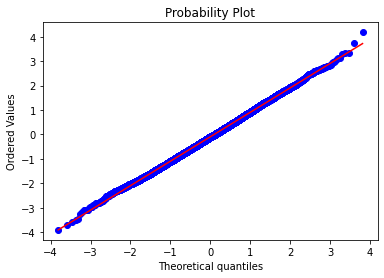

In [414]:
res = scistats.probplot(r_sem, dist="norm", plot = plt)

In [415]:
scistats.normaltest(residuals_sem)

NormaltestResult(statistic=10.686049748790344, pvalue=0.004781385722461336)

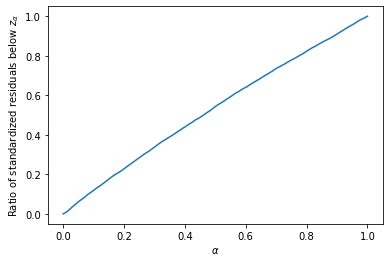

In [416]:
a = []
for q in np.linspace(0.00, 1.00, 100):
    a.append(len(residuals_sem[residuals_sem < get_tol(q, T, sigma, n)]) / np.shape(residuals_sem)[0])

plt.xlabel(r"$\alpha$")
plt.ylabel(r"Ratio of standardized residuals below $z_{\alpha}$")
plt.plot(np.linspace(0.00, 1.00, 100), a)

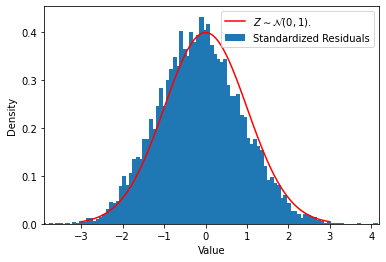

In [417]:
n_bins = 100
hist, bin_edges = np.histogram(r_sem, bins = n_bins, density = True)
plt.bar(bin_edges[:-1], hist, width = 10 / n_bins, label = "Standardized Residuals")
plt.plot(x, scistats.norm.pdf(np.linspace(-3, 3, 100), 0.0, 1), color = 'red', label = r"$Z \sim \mathcal{N}(0, 1)$.")
plt.xlim(min(bin_edges), max(bin_edges))
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()   

Smaller samples, then we can capitalize more on the noise, we can overfit more easily. Therefore, the residual will always be slightly lower than what we expect, since our $W$ overfits more and hence is slightly "better" than $W\_true$. As $T$ grows to infinity, $W$ and $W\_true$ will become equal, and therefore, we will get the normal distribution again.

However, for small $T$, OMP will not even recover $W\_true$, not even the coefficients, so therefore this looks off.